In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


**Не бесконечный список**
* [Загрузка данных](#load)
    * [описание датасета](#desc)
    * [приведение типов](#dtypes)
* [1. EDA](#eda)
    * [Анализ целевого признака](#target)
    * [Анализ вещественных признаков](#floatint)
    * [Анализ категориальных признаков](#object)
    * [Корреляции](#corr)
    * [Обработка выбросов](#outlier)
    * [Обработка пропусков](#nan)
    * [Построение новых признаков](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

**Подключение библиотек и скриптов**

In [4]:
import numpy as np
import pandas as pd
from random import randint 
from scipy.stats import mode

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

**Шрифты**

In [6]:
matplotlib.rcParams.update({'font.size': 16})

**Функция оценки предсказаний по R2-метрике**

In [7]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print(f'Train R2: {round(r2_score(train_true_values, train_pred_values), 3)},\
            Test R2:{round(r2_score(test_true_values, test_pred_values), 3)}')
    
    check_train = pd.DataFrame({
        "true": train_true_values,
        "pred": train_pred_values.flatten(),
    })

    check_test = pd.DataFrame({
        "true": test_true_values,
        "pred": test_pred_values.flatten(),
    })

    sns.scatterplot(data=check_train, x="pred", y="true", alpha=0.5, label="Train")
    sns.scatterplot(data=check_test, x="pred", y="true", alpha=0.5, label="Test")

**Функция уменьшения использования памяти**

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Пути к директориям и файлам**

In [113]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'
SAMPLE_PATH = '/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv'

## Загрузка данных <a class='anchor' id='load'>

### Описание датасета <a class='anchor' id='desc'>

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [10]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [11]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [12]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


In [13]:
print(f'Train shape: {train_df.shape}\nTest shape: {test_df.shape}')

Train shape: (10000, 20)
Test shape: (5000, 19)


In [14]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов <a class='anchor' id='dtypes'>

In [15]:
train_df.select_dtypes(include=['object']).sample(frac=1).head(10)

,Ecology_2,Ecology_3,Shops_2
7320,B,B,B
4095,B,B,B
7547,B,B,B
2881,B,B,B
6164,B,B,B
7894,B,B,B
5869,B,B,B
3523,B,B,B
8330,A,B,B
3220,B,B,B


In [16]:
train_df.select_dtypes(include=['float64', 'int64']).sample(frac=1).head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
8214,8217,9,3.0,61.408980,46.293965,6.0,7,9.0,1977,0.130123,8,1986,0,NaN,0,0,181043.993280
5499,9327,12,2.0,58.992068,36.722757,10.0,8,17.0,1995,0.090799,74,19083,2,NaN,5,15,297144.369693
8890,4187,94,3.0,56.791798,37.355487,6.0,2,9.0,1972,0.282798,33,8667,2,NaN,0,6,249188.275443
2784,100,39,4.0,68.986463,47.424485,6.0,4,9.0,1972,0.428826,25,5011,8,730.0,0,2,228788.566408
3740,5432,119,1.0,35.073708,21.902379,5.0,4,9.0,1964,0.000995,42,7651,1,NaN,1,5,163383.838449
6336,4986,27,2.0,47.888508,44.050835,1.0,4,12.0,2013,0.072158,2,629,1,NaN,0,0,134605.887733
7076,6404,119,1.0,40.242909,23.772968,9.0,10,16.0,1978,0.033494,66,10573,1,1322.0,3,8,155440.820605
7506,16687,6,2.0,51.468078,34.685718,9.0,4,17.0,1977,0.243205,5,1564,0,540.0,0,0,142441.890637
8417,3810,1,3.0,80.921144,47.018777,10.0,9,17.0,1989,0.025609,33,5261,0,240.0,3,1,294343.765902
2560,981,23,2.0,64.426277,61.358680,1.0,19,25.0,1977,0.075779,6,1437,3,NaN,0,2,175836.385259


In [17]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## EDA <a class='anchor' id='eda'>

In [19]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Функция подсчёта уникальных значений признаков**

In [20]:
def num_unique(df):
    """
        Returns pd.DataFrame with names of features as index, 
        number of feature unique values and feature type as columns,
        sorted by nunique()
    """
    object_cols = df.select_dtypes(include='object')
    object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
    o = dict(zip(object_cols, object_nunique))
    
    num_cols = df.select_dtypes(include=['float', 'int'])
    num_nunique = list(map(lambda col: df[col].nunique(), num_cols))
    n = dict(zip(num_cols, num_nunique))
    
    reso = pd.DataFrame.from_dict(o, orient='index', columns=['nunique'])
    reso['type'] = 'object'
    
    resn = pd.DataFrame.from_dict(n, orient='index', columns=['nunique'])
    resn['type'] = 'float/int'
    
    res = pd.concat([reso, resn], axis=0)
    
    return res.sort_values(by='nunique')

### Анализ целевой переменной <a id='target'>

**Распределение целевой переменной**

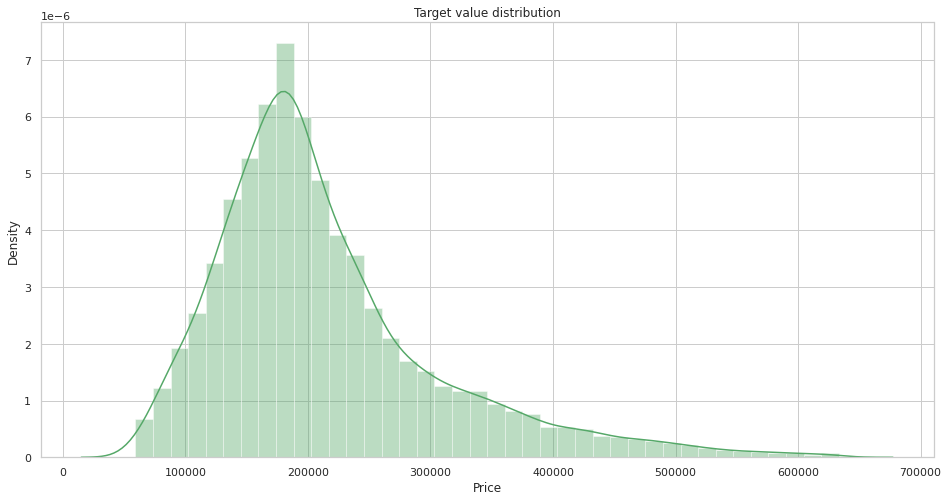

In [21]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 8))
sns.distplot(train_df['Price'], color='g', bins=40);
plt.title('Target value distribution');

### Анализ вещественных переменных <a id='floatint'>

**Распределение непрерывных величин**

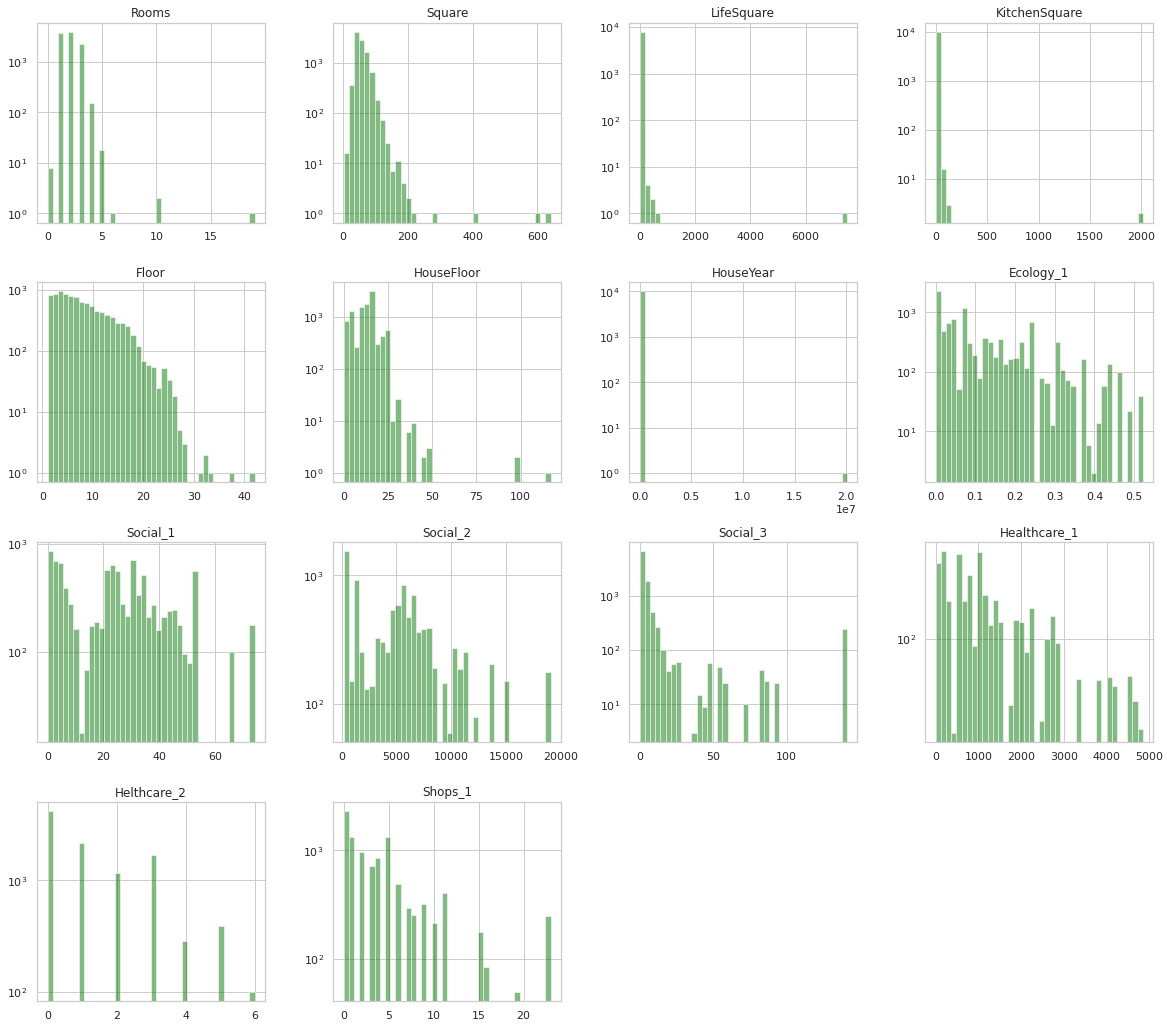

In [22]:
floatint_df = train_df.select_dtypes(include=['float64', 'int64']).drop('Price', axis=1)
floatint_df.hist(figsize=(20, 18), bins=40, log=True, color='#097506', alpha=.5);

In [23]:
train_df.Square.quantile(.975)

100.90624548226137

Посмотрим, как в общем соотносятся значения фактической и жилой площади 

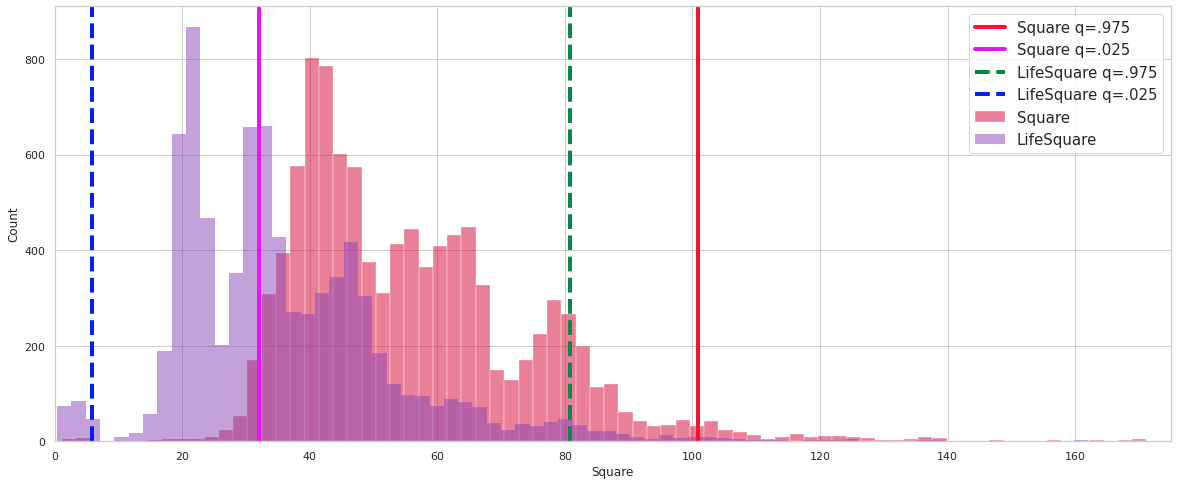

In [24]:
plt.figure(figsize=(20, 8))

sns.histplot(train_df.Square, 
             color='#d60330', 
             alpha=0.5, label='Square');
sns.histplot(train_df.LifeSquare, 
             color='#8844b8', 
             alpha=0.5, label='LifeSquare').set(xlim=(0, 175));

plt.axvline(train_df.Square.quantile(.975), 
            color='#f61330',
            linewidth=4, 
            label='Square q=.975')
plt.axvline(train_df.Square.quantile(.025), 
            color='#e515f7',
            linewidth=4, 
            label='Square q=.025')

plt.axvline(train_df.LifeSquare.quantile(.975), 
            color='#098848', 
            linewidth=4, 
            label='LifeSquare q=.975', 
            linestyle='--')
plt.axvline(train_df.LifeSquare.quantile(.025), 
            color='#021ff7', 
            linewidth=4, 
            label='LifeSquare q=.025', 
            linestyle='--')

plt.legend(fontsize=15);

Посмотрим на строки, где значение жилой площади превосходит значение фактическое

In [25]:
train_df.loc[train_df.Square < train_df.LifeSquare, ['Square', 'LifeSquare']]

,Square,LifeSquare
33,73.314975,74.131261
64,87.200625,87.730225
77,38.467276,39.624493
100,79.937665,82.931595
111,28.438794,32.514021
...,...,...
9960,96.056784,98.152802
9962,42.029175,44.682167
9979,40.043234,41.984322
9987,62.690057,64.602939


Почти для половины всех имеющихся данных значение признака Healthcare_1 не определено:

In [26]:
train_df.Healthcare_1.isna().value_counts()

False    5202
True     4798
Name: Healthcare_1, dtype: int64

In [27]:
train_df.Healthcare_1.describe()

count    5202.000000
mean     1142.904460
std      1021.517264
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

### Анализ категориальных признаков <a id='object'>

In [28]:
obj_df = train_df.select_dtypes(include=['object'])
obj_df

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
0,11809,27,B,B,B
1,3013,22,B,B,B
2,8215,1,B,B,B
3,2352,1,B,B,B
4,13866,94,B,B,B
...,...,...,...,...,...
9995,1260,61,B,B,B
9996,16265,27,B,B,A
9997,2795,178,B,B,B
9998,14561,21,B,B,B


In [29]:
num_unique(obj_df)

,nunique,type
Ecology_2,2,object
Ecology_3,2,object
Shops_2,2,object
DistrictId,205,object
Id,10000,object


In [30]:
obj_df.DistrictId.describe()

count     10000
unique      205
top          27
freq        851
Name: DistrictId, dtype: object

In [31]:
obj_df.Ecology_3.value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [32]:
obj_df.Shops_2.value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

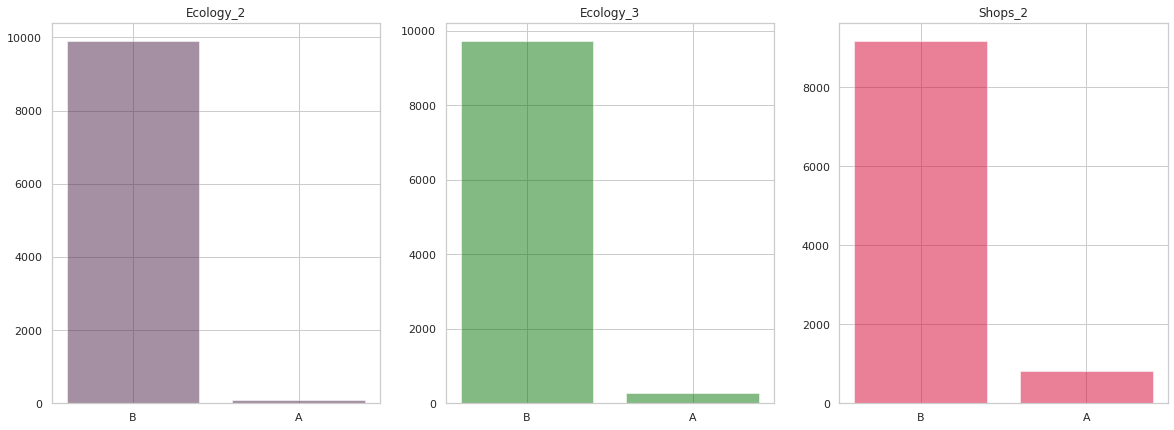

In [33]:
ecology2_count = obj_df.Ecology_2.value_counts()
ecology3_count = obj_df.Ecology_3.value_counts()
shops2_count = obj_df.Shops_2.value_counts()

fig, axs = plt.subplots(1, 3, figsize=(20, 7)) 

axs[0].bar(ecology2_count.index, ecology2_count.values, color='#4a2347', alpha=0.5)
axs[0].set_title('Ecology_2')
axs[1].bar(ecology3_count.index, ecology3_count.values, color='#097506', alpha=0.5)
axs[1].set_title('Ecology_3')
axs[2].bar(shops2_count.index, shops2_count.values, color='#d60330', alpha=0.5)
axs[2].set_title('Shops_2')

plt.show()

### Корреляции

**Зависимость целевой переменной от вещественных признаков**

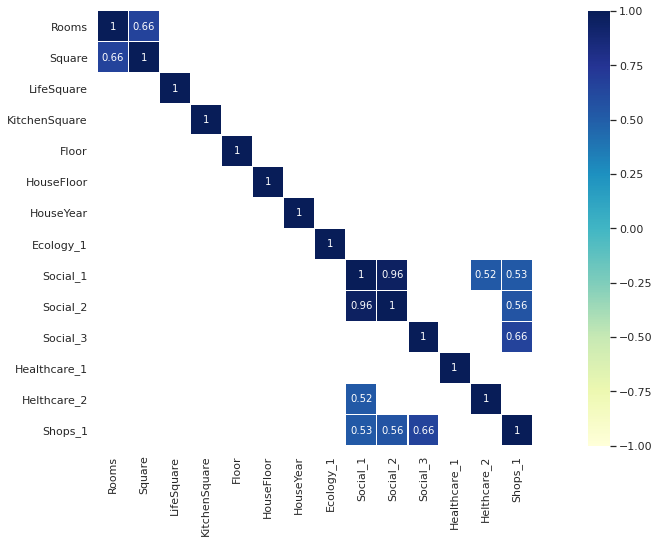

In [34]:
def make_heatmap(df):
    corr = df.corr()
    plt.figure(figsize=(20, 8))
    sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
                cmap='YlGnBu', vmax=1.0, vmin=-1.0, linewidths=0.1,
                annot=True, annot_kws={"size": 10}, square=True);
make_heatmap(floatint_df)

**Функция вычисления сильных корреляций, возвращающая pd.Series**

In [35]:
def calc_strongly_corr(df, target):
    
    df_corr = df.corr()[target]
    golden_features_list = df_corr[(abs(df_corr) > 0.5) & \
                                   (df_corr != 1)].sort_values(ascending=False)
    
    return target, golden_features_list

In [36]:
target, feat = calc_strongly_corr(train_df.select_dtypes(['float64', 'int64']), 'Price')
print(f"There is {len(feat)} strongly correlated values with {target}:\n{feat}")

There is 2 strongly correlated values with Price:
Rooms     0.550291
Square    0.520075
Name: Price, dtype: float64


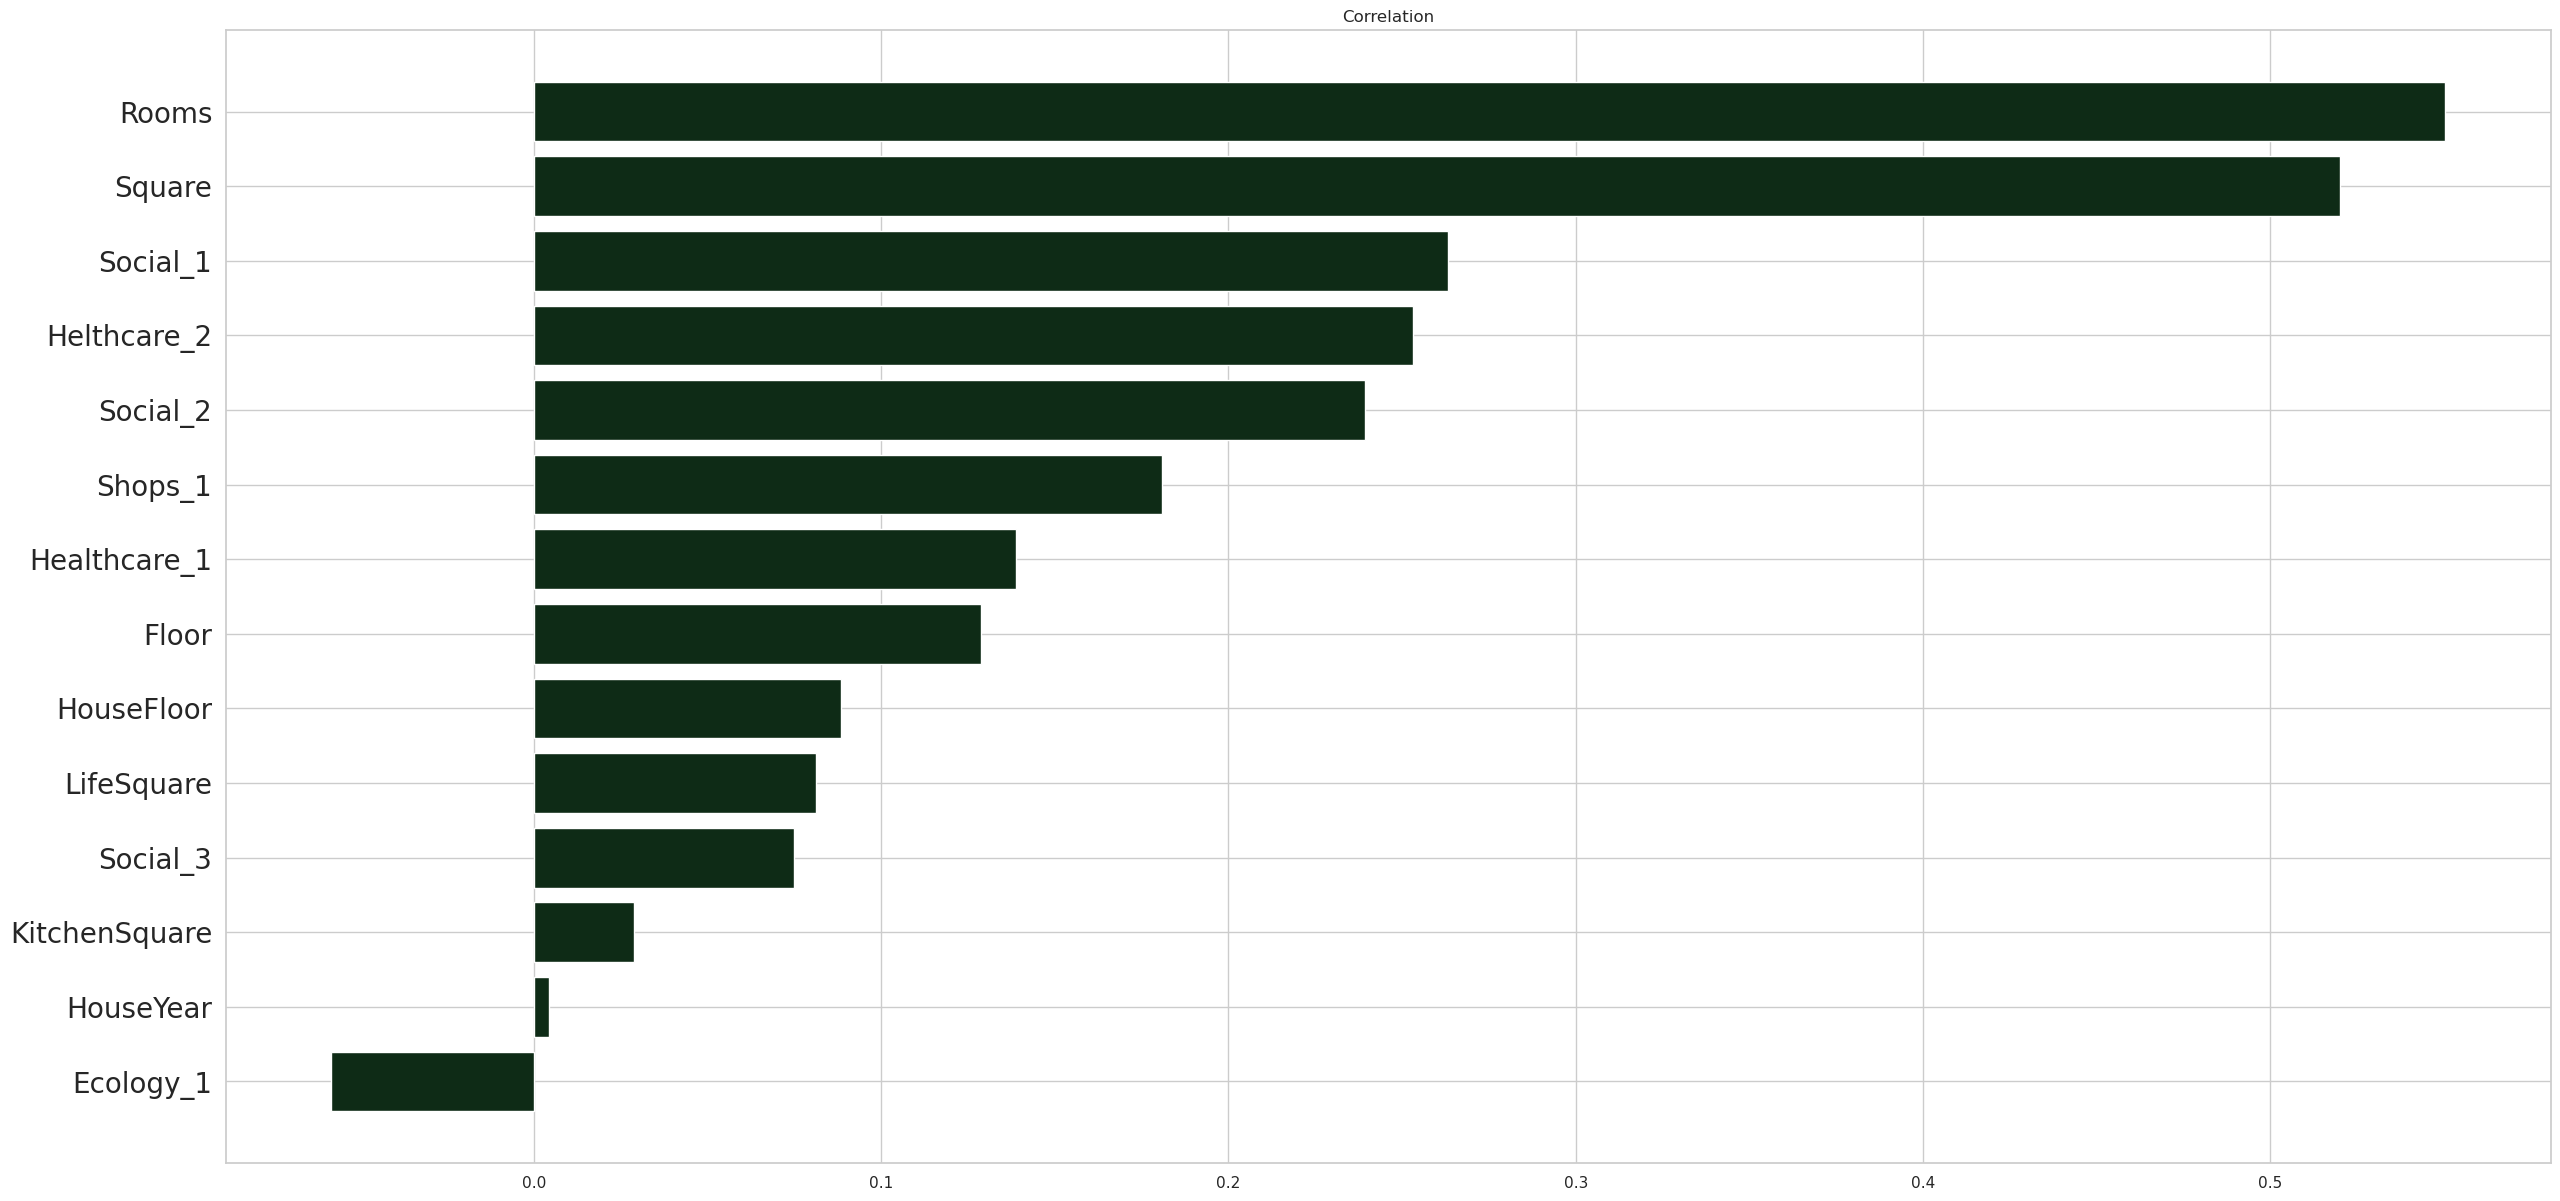

In [37]:
def make_barplot_corr(df, target, above_null=True):
    """
        Returns horizontal histogram based on the correlation values 
        of numerical features with the target variable
    """
    df_corr = df.corr()[target]
    if above_null == True:
        scores = df_corr[(df_corr != 1) & \
                                      (df_corr > 0)].sort_values(ascending=False)
    else:
        scores = df_corr[(df_corr != 1)].sort_values(ascending=False)
    y = scores.sort_values(ascending=True)
    width = np.arange(len(y))
    ticks = list(y.index)
    plt.barh(width, y, color='#0e2b16')
    plt.yticks(width, ticks, fontsize=20)
    plt.title("Correlation")

plt.figure(dpi=100, figsize=(30, 15))
make_barplot_corr(train_df, 'Price', above_null=False)

## Предобработка данных

### Обработка выбросов <a id='outlier'>

#### *Rooms*

In [38]:
train_df.Rooms.value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [39]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df.Rooms == 0) | \
             (train_df.Rooms > train_df.Rooms.quantile(.985)), 'Rooms_outlier'] = 1
train_df.Rooms[train_df.Rooms == 0] = 1

train_df.Rooms.clip(0, train_df.Rooms.quantile(.985), inplace=True)
train_df.Rooms.value_counts()

2.0    3880
1.0    3713
3.0    2235
4.0     172
Name: Rooms, dtype: int64

In [40]:
train_df.Rooms_outlier.value_counts()

0    9970
1      30
Name: Rooms_outlier, dtype: int64

#### *Square*

In [41]:
train_df['Square_outlier'] = 0
train_df.loc[train_df.Square > train_df.Square.quantile(.975), 'Square_outlier'] = 1 
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,11,3097,0,NaN,0,0,B,305018.871089,0,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,B,177734.553407,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,B,282078.720850,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,1,264,0,NaN,0,1,B,168106.007630,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,33,8667,2,NaN,0,6,B,343995.102962,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,52,10311,6,NaN,1,9,B,119367.455796,0,0
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,...,2,629,1,NaN,0,0,A,199715.148807,0,0
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,20,4386,14,NaN,1,5,B,165953.912580,0,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,47,8004,3,125.0,3,5,B,171842.411855,0,0


In [42]:
train_df.Square.quantile(.975), train_df.Square.quantile(.025)

(100.90624548226137, 32.10518291149681)

In [43]:
train_df.Square.clip(train_df.Square.quantile(.975), train_df.Square.quantile(.025), inplace=True)
train_df.Square

0       100.906245
1        39.832524
2        78.342215
3        40.409907
4        64.285067
           ...    
9995     49.090728
9996     64.307684
9997     32.105183
9998     32.330292
9999     35.815476
Name: Square, Length: 10000, dtype: float64

#### *LifeSquare*

In [45]:
non_adjective = train_df.loc[train_df.Square < train_df.LifeSquare, ['Square', 'LifeSquare']].index
life_square_max_value = train_df.LifeSquare.quantile(.975)
life_square_min_value = train_df.LifeSquare.quantile(.025)

train_df['LifeSquare_outlier'] = 0
train_df.loc[non_adjective, 'LifeSquare_outlier'] = 1 
train_df.loc[(train_df.LifeSquare > life_square_max_value) | (train_df.LifeSquare < life_square_min_value), 'LifeSquare_outlier'] = 1

train_df.LifeSquare.clip(life_square_min_value, life_square_max_value)

train_df.LifeSquare_outlier.value_counts()

0    9229
1     771
Name: LifeSquare_outlier, dtype: int64

In [46]:
train_df.loc[non_adjective, 'LifeSquare'] = train_df.loc[non_adjective, \
                                                         'Square'].apply(lambda x: np.random.uniform(1,x))
# Проверим, остались ли неадекватные значения
train_df.loc[train_df.Square < train_df.LifeSquare, ['Square', 'LifeSquare']]

,Square,LifeSquare


#### *Floor, HouseFloor*

In [47]:
print(f'Floor 0 count: {train_df.Floor.isin([0]).sum()}')
print(f'HouseFloor 0 count: {train_df.HouseFloor.isin([0]).sum()}')

Floor 0 count: 0
HouseFloor 0 count: 269


In [48]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[(train_df.HouseFloor < 0) | \
             (train_df.HouseFloor > train_df.HouseFloor.quantile(.975)), 'HouseFloor_outlier'] = 1

non_adjective = train_df.loc[(train_df['Floor'] > train_df['HouseFloor'])].index

train_df['Floor_outlier'] = 0
train_df.loc[non_adjective, 'Floor_outlier'] = 1
train_df.HouseFloor_outlier.value_counts()

0    9940
1      60
Name: HouseFloor_outlier, dtype: int64

In [49]:
train_df['HouseFloor'] = train_df.HouseFloor.clip(1, train_df.HouseFloor.quantile(.975))
train_df.loc[non_adjective, 'Floor'] = train_df.loc[non_adjective, 'HouseFloor'].apply(lambda x: randint(1,x))

In [50]:
train_df.loc[:, ['HouseFloor', 'Floor', 'HouseFloor_outlier']].sample(frac=1).head(10)

,HouseFloor,Floor,HouseFloor_outlier
6717,12.0,6,0
723,9.0,9,0
2284,4.0,3,0
3127,14.0,11,0
6498,12.0,3,0
6336,12.0,4,0
5763,17.0,11,0
8136,12.0,5,0
5803,1.0,1,0
8146,23.0,14,0


#### *KitchenSquare*

In [51]:
condition = (train_df.KitchenSquare > train_df.KitchenSquare.quantile(.975)) \
| (train_df.KitchenSquare < 3)
train_df['kitchen_outlier'] = 0
train_df.loc[condition, 'kitchen_outlier'] = 1

train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

train_df.KitchenSquare.describe()

count    10000.000000
mean         7.186500
std          1.901073
min          3.000000
25%          6.000000
50%          6.000000
75%          8.000000
max         13.000000
Name: KitchenSquare, dtype: float64

#### *HouseYear*

In [52]:
train_df.HouseYear.sort_values()

6794        1910
2795        1912
2066        1912
6250        1914
7610        1916
          ...   
8296        2020
2350        2020
7246        2020
8828        4968
9163    20052011
Name: HouseYear, Length: 10000, dtype: int64

In [53]:
train_df.loc[train_df.HouseYear > 2020, 'HouseYear'] = 2020

In [54]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,kitchen_outlier
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.886600,55.808219,33.965722,7.186500,7.235300,12.564600,1984.872400,0.118858,24.687000,5352.157400,...,1142.904460,1.319500,4.231300,214138.857399,0.003000,0.025000,0.077100,0.006000,0.182500,0.335000
std,0.806725,17.214605,15.443584,1.901073,5.100445,6.398853,18.416347,0.119025,17.532614,4006.799803,...,1021.517264,1.493601,4.806341,92872.293865,0.054693,0.156133,0.266763,0.077231,0.386275,0.472014
min,1.000000,32.105183,0.370619,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.774881,22.366916,6.000000,3.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,...,350.000000,0.000000,1.000000,153872.633942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,52.513310,31.849880,6.000000,6.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,...,900.000000,1.000000,3.000000,192269.644879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,65.900625,43.509995,8.000000,10.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,...,1548.000000,2.000000,6.000000,249135.462171,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,4.000000,100.906245,100.201652,13.000000,42.000000,25.000000,2020.000000,0.521867,74.000000,19083.000000,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Обработка пропусков <a class='anchor' id='nan'>

In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  object 
 1   DistrictId          10000 non-null  object 
 2   Rooms               10000 non-null  float64
 3   Square              10000 non-null  float64
 4   LifeSquare          7887 non-null   float64
 5   KitchenSquare       10000 non-null  float64
 6   Floor               10000 non-null  int64  
 7   HouseFloor          10000 non-null  float64
 8   HouseYear           10000 non-null  int64  
 9   Ecology_1           10000 non-null  float64
 10  Ecology_2           10000 non-null  object 
 11  Ecology_3           10000 non-null  object 
 12  Social_1            10000 non-null  int64  
 13  Social_2            10000 non-null  int64  
 14  Social_3            10000 non-null  int64  
 15  Healthcare_1        5202 non-null   float64
 16  Helth

#### *LifeSquare*

In [56]:
lifesquare_nan = train_df.LifeSquare.isna()
train_df['lifesquare_nan'] = 0
train_df.loc[lifesquare_nan, 'lifesquare_nan'] = 1

In [57]:
feature_names = ['Rooms','Square', 'KitchenSquare']
Xs = train_df.loc[~lifesquare_nan, feature_names]
ys = train_df.loc[~lifesquare_nan, ['LifeSquare']]
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size = 0.3, random_state=42, shuffle=True)
model = RandomForestRegressor(max_depth=3,random_state=2)
model.fit(X_train, y_train.values[:,0])

RandomForestRegressor(max_depth=3, random_state=2)

Train R2: 0.543,            Test R2:0.548


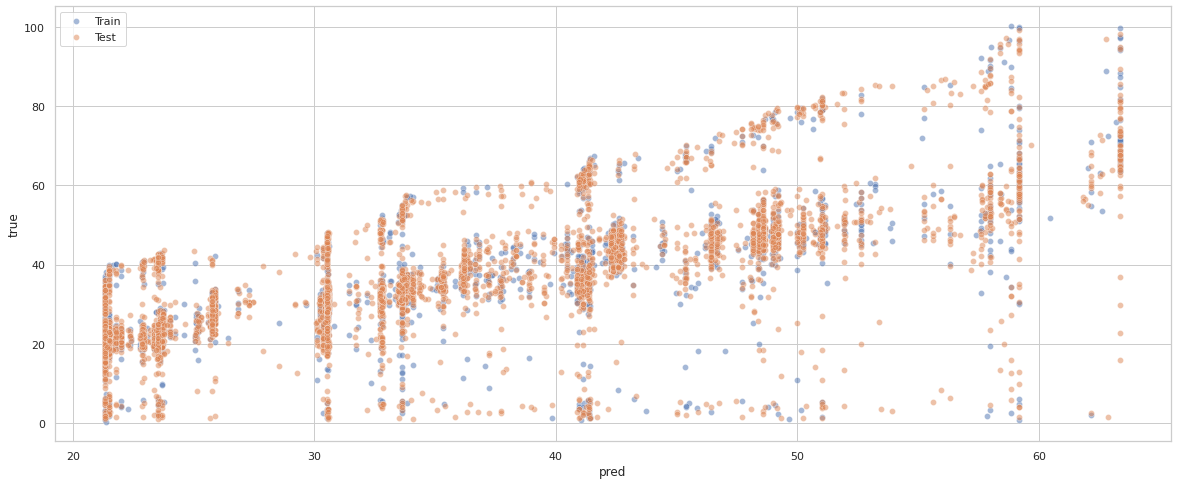

In [58]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

plt.figure(figsize=(20, 8))
evaluate_preds(y_test["LifeSquare"], 
               y_test_pred.flatten(), 
               y_train["LifeSquare"], 
               y_train_pred.flatten())

In [59]:
train_df.loc[lifesquare_nan, 'LifeSquare'] = \
model.predict(train_df.loc[lifesquare_nan, feature_names])

#### *Healthcare_1*

In [60]:
nan_healthcare = train_df.Healthcare_1.isna()

In [61]:
train_df['healthcare_nan'] = 0
train_df.loc[nan_healthcare, 'healthcare_nan'] = 1

In [62]:
train_df.healthcare_nan.value_counts()

0    5202
1    4798
Name: healthcare_nan, dtype: int64

In [63]:
feature_names = ['Floor','HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Social_3','LifeSquare','Rooms','Square','Helthcare_2','Shops_1']
Xs = train_df.loc[~nan_healthcare, feature_names]
ys = train_df.loc[~nan_healthcare, ['Healthcare_1']]
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size = 0.3, random_state=42, shuffle=True)
model = RandomForestRegressor(max_depth=10,random_state=42)
model.fit(X_train, y_train.values[:,0])

RandomForestRegressor(max_depth=10, random_state=42)

In [64]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

Train R2: 0.998,            Test R2:0.999


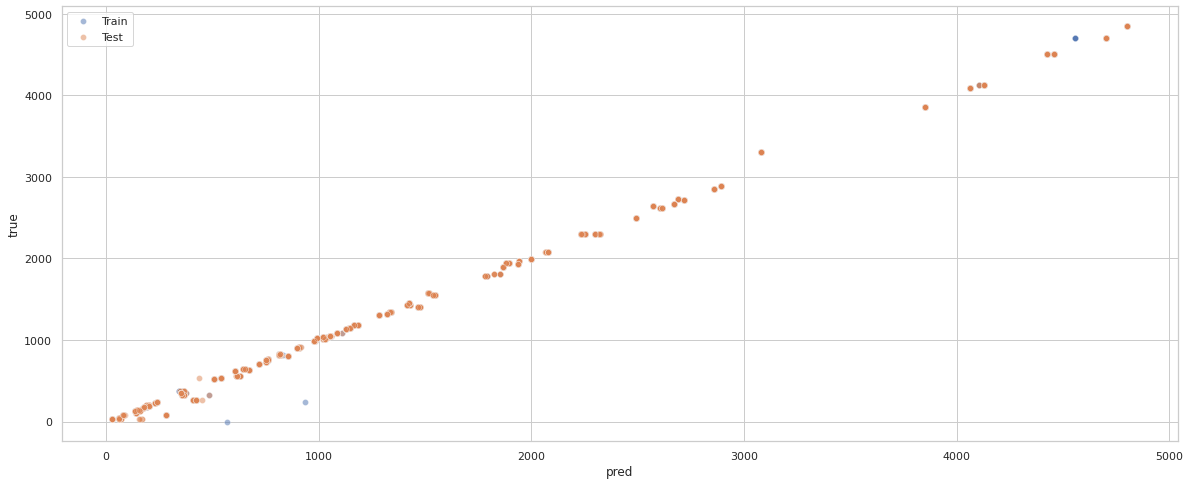

In [65]:
plt.figure(figsize=(20, 8))
evaluate_preds(y_test["Healthcare_1"], 
               y_test_pred.flatten(), 
               y_train["Healthcare_1"], 
               y_train_pred.flatten())

In [66]:
train_df.loc[nan_healthcare, 'Healthcare_1'] = \
model.predict(train_df.loc[nan_healthcare, feature_names])

In [67]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Shops_1,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,kitchen_outlier,lifesquare_nan,healthcare_nan
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.886600,55.808219,34.527818,7.186500,7.235300,12.564600,1984.872400,0.118858,24.687000,5352.157400,...,4.231300,214138.857399,0.003000,0.025000,0.077100,0.006000,0.182500,0.335000,0.211300,0.479800
std,0.806725,17.214605,14.709212,1.901073,5.100445,6.398853,18.416347,0.119025,17.532614,4006.799803,...,4.806341,92872.293865,0.054693,0.156133,0.266763,0.077231,0.386275,0.472014,0.408251,0.499617
min,1.000000,32.105183,0.370619,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,...,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.774881,22.919865,6.000000,3.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,...,1.000000,153872.633942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,52.513310,32.700549,6.000000,6.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,...,3.000000,192269.644879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,65.900625,43.581262,8.000000,10.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,...,6.000000,249135.462171,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,4.000000,100.906245,100.201652,13.000000,42.000000,25.000000,2020.000000,0.521867,74.000000,19083.000000,...,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**DataPrepocessing**

In [68]:
class DataPreprocessing:
    '''Подготовка исходных данных'''
    def __init__(self):
        '''Параметры класса'''
        self.medians = None
        self.rooms_quantile = None
        self.kitchen_square_quantile = None
        self.square_quantile_min = None
        self.square_quantile_max = None
        self.life_square_quantile_min = None
        self.life_square_quantile_max = None
        self.house_floor_quantile = None
        self.h1_feature_names = None
        self.ls_feature_names = None
        self.model_healthcare_1 = None
        self.model_lifesquare = None

    def fit(self, X):
        '''Сохранение статистик'''
        # train
        self.medians = X.median()
        self.rooms_quantile = X.Rooms.quantile(.985)
        self.kitchen_square_quantile = X.KitchenSquare.quantile(.975)
        self.square_quantile_max = X.Square.quantile(.975)
        self.square_quantile_min = X.Square.quantile(.025)
        self.life_square_quantile_max = X.LifeSquare.quantile(.975)
        self.life_square_quantile_min = X.LifeSquare.quantile(.025)
        self.house_floor_quantile = X.HouseFloor.quantile(.975)
        self.h1_feature_names = [
            'Floor','HouseFloor','HouseYear','Ecology_1','Social_1','Social_2',
            'Social_3','LifeSquare','Rooms','Square','Helthcare_2','Shops_1'
        ]
        self.ls_feature_names = ['Rooms', 'Square', 'KitchenSquare']

    def transform(self, X):
        '''Трансформация данных'''
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X.Rooms == 0) | \
             (X.Rooms > self.rooms_quantile), 'Rooms_outlier'] = 1
        X.Rooms[X.Rooms == 0] = 1
        
        X.Rooms.clip(0, 
                     self.rooms_quantile, 
                     inplace=True)
        
        # Square
        condition = (X.Square > self.square_quantile_max) | \
        (X.Square < self.square_quantile_min)
        X['Square_outlier'] = 0
        X.loc[condition, 'Square_outlier'] = 1 
        
        X.Square.clip(self.square_quantile_min, 
                      self.square_quantile_max, 
                      inplace=True)
        
        # KitchenSquare
        condition = (X.KitchenSquare > self.kitchen_square_quantile) \
        | (X.KitchenSquare < 3)
        X['kitchen_outlier'] = 0
        X.loc[condition, 'kitchen_outlier'] = 1

        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor
        X['HouseFloor_outlier'] = 0
        X.loc[(X.HouseFloor < 0) | \
             (X.HouseFloor > self.house_floor_quantile), 'HouseFloor_outlier'] = 1
        
        # Floor
        non_adjective = (X['Floor'] > X['HouseFloor'])
        X['Floor_outlier'] = 0
        X.loc[non_adjective, 'Floor_outlier'] = 1
        
        X['HouseFloor'] = X.HouseFloor.clip(1, self.house_floor_quantile)
        X.loc[non_adjective, 'Floor'] = X.loc[non_adjective, 'HouseFloor'].apply(lambda x: randint(1,x))
        
        # HouseYear
        current_year = datetime.now().year
        X['HouseYear_outlier'] = 0
        X.loc[X.HouseYear > current_year, 'HouseYear_outlier'] = 1

        X.loc[X.HouseYear > current_year, 'HouseYear'] = current_year

        # LifeSquare
        non_adjective = X.loc[X.Square < X.LifeSquare, ['Square', 'LifeSquare']].index
        
        X['LifeSquare_outlier'] = 0
        X.loc[non_adjective, 'LifeSquare_outlier'] = 1 
        X.loc[(X.LifeSquare > self.life_square_quantile_max) | \
              (train_df.LifeSquare < life_square_min_value), 'LifeSquare_outlier'] = 1

        X.LifeSquare.clip(self.life_square_quantile_min, 
                          self.life_square_quantile_max, 
                          inplace=True)
        
        lifesquare_nan = X.LifeSquare.isna()
        X['lifesquare_nan'] = 0
        X.loc[lifesquare_nan, 'lifesquare_nan'] = 1
        if not self.model_lifesquare:
            
            Xs = X.loc[~lifesquare_nan, self.ls_feature_names]
            ys = X.loc[~lifesquare_nan, ['LifeSquare']]
            X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size = 0.3, random_state=40, shuffle=True)
            self.model_lifesquare = RandomForestRegressor(max_depth=4, random_state=41)
            self.model_lifesquare.fit(X_train, y_train.values[:,0])
            y_train_pred = self.model_lifesquare.predict(X_train)
            y_test_pred = self.model_lifesquare.predict(X_test)
            r2_forest_test = r2_score(y_test['LifeSquare'], y_test_pred.flatten())
            r2_forest_train = r2_score(y_train['LifeSquare'], y_train_pred.flatten())
            print(f'Test R2 LifeSquare {r2_forest_test}, Train R2 LifeSquare: {r2_forest_train}')
        X.loc[lifesquare_nan, 'LifeSquare'] = self.model_lifesquare.predict(X.loc[lifesquare_nan, self.ls_feature_names])
    
        # Healthcare_1
        nan_healthcare = (X.Healthcare_1.isna())
        X['healthcare_nan'] = 0
        X.loc[nan_healthcare, 'healthcare_nan'] = 1
        if not self.model_healthcare_1:
            
            Xs = X.loc[~nan_healthcare, self.h1_feature_names]
            ys = X.loc[~nan_healthcare, ['Healthcare_1']]
            X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size = 0.3, random_state=42, shuffle=True)
            self.model_healthcare_1 = RandomForestRegressor(max_depth=10,random_state=42)
            self.model_healthcare_1.fit(X_train, y_train.values[:,0])
            y_train_pred = self.model_healthcare_1.predict(X_train)
            y_test_pred = self.model_healthcare_1.predict(X_test)
            r2_forest_test = r2_score(y_test['Healthcare_1'], y_test_pred.flatten())
            r2_forest_train = r2_score(y_train['Healthcare_1'], y_train_pred.flatten())
            print(f'Test R2 Healthcare: {r2_forest_test}, Train R2 Healtcare: {r2_forest_train}')

        X.loc[nan_healthcare, 'Healthcare_1'] = self.model_healthcare_1.predict(X.loc[nan_healthcare, self.h1_feature_names])

        X.fillna(self.medians, inplace=True)

        return X

### Построение новых признаков <a class='anchor' id='feature'>

#### **Discrete feature binarization**

##### *Ecology_2, Ecology_3, Shops_2*

In [69]:
binary_dict = {'A': 0, 'B': 1}
train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_dict)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_dict)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_dict)

In [70]:
train_df[['Ecology_2', 'Ecology_3', 'Shops_2']]

,Ecology_2,Ecology_3,Shops_2
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
9995,1,1,1
9996,1,1,0
9997,1,1,1
9998,1,1,1


#### **Feature Encoding**

##### *LSS* (Square-LifeSquare ratio) 

In [71]:
lss_ratio = pd.DataFrame({'Square': train_df.Square,'LifeSquare': train_df.LifeSquare, 'LSS': round((train_df.LifeSquare / train_df.Square), 2)})

In [72]:
train_df = train_df.merge(lss_ratio, on=['Square', 'LifeSquare'], how='left')

In [73]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,kitchen_outlier,lifesquare_nan,healthcare_nan,LSS
0,11809,27,3.0,100.906245,59.195670,10.0,4,10.0,2014,0.075424,...,305018.871089,0,1,0,0,0,0,1,1,0.59
1,11809,27,3.0,100.906245,59.195670,10.0,4,10.0,2014,0.075424,...,305018.871089,0,1,0,0,0,0,1,1,0.59
2,11809,27,3.0,100.906245,59.195670,10.0,4,10.0,2014,0.075424,...,305018.871089,0,1,0,0,0,0,1,1,0.59
3,11809,27,3.0,100.906245,59.195670,10.0,4,10.0,2014,0.075424,...,305018.871089,0,1,0,0,0,0,1,1,0.59
4,11809,27,3.0,100.906245,59.195670,10.0,4,10.0,2014,0.075424,...,305018.871089,0,1,0,0,0,0,1,1,0.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13723,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,119367.455796,0,0,0,0,0,0,0,1,0.68
13724,16265,27,2.0,64.307684,37.038420,9.0,1,1.0,1977,0.072158,...,199715.148807,0,0,0,0,1,0,0,1,0.58
13725,2795,178,1.0,32.105183,16.555363,5.0,3,5.0,1958,0.460556,...,165953.912580,0,0,0,0,0,0,0,1,0.52
13726,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,171842.411855,0,0,0,0,0,0,0,0,0.69


##### *LSSperRoom ratio* 

In [74]:
# lss_per_room = round(((train_df.LifeSquare / train_df.Square) / train_df.Rooms), 2)
lss_per_room = pd.DataFrame({'Square': train_df.Square,'LifeSquare': train_df.LifeSquare, 
                             'LSSperRoom': round(train_df.LSS / train_df.Rooms, 2)})
train_df = train_df.merge(lss_per_room, on=['Square', 'LifeSquare'], how='left')

##### *DistrictSize, IsDistrictLarge*

In [75]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
train_df = train_df.merge(district_size, on='DistrictId', how='left')

In [76]:
train_df['DistrictSize'].fillna(4, inplace=True)
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)
train_df.IsDistrictLarge.value_counts()

1    8713774
0       4466
Name: IsDistrictLarge, dtype: int64

##### *DistrictNumStoreys, IsHighRise*

In [77]:
# Посчитаем этажность районов и создадим метку многоэтажности

In [78]:
district_num_storeys = train_df.groupby(by='DistrictId').HouseFloor.apply(lambda x: x.mode()[0]).reset_index()\
                    .rename(columns={'index':'DistrictId', 'HouseFloor':'DistrictNumStoreys'})
district_num_storeys.head()

,DistrictId,DistrictNumStoreys
0,0,5.0
1,1,1.0
2,10,9.0
3,100,5.0
4,101,5.0


In [79]:
train_df = train_df.merge(district_num_storeys, on=['DistrictId'], how='left')

train_df['IsHighRise'] = 0
train_df.loc[train_df.DistrictNumStoreys > \
             train_df.DistrictNumStoreys.median(), 'IsHighRise'] = 1 

In [80]:
train_df.IsHighRise.value_counts()

0    5336824
1    3381416
Name: IsHighRise, dtype: int64

#### **Target Encoding**

##### *MedPriceByNumStoreys*

In [81]:
med_price_by_num_storeys = train_df.groupby(by='DistrictNumStoreys', as_index=False).agg({'Price':'median'})\
                    .rename(columns={'index':'DistrictId', 'Price':'MedPriceByNumStoreys'})
train_df = train_df.merge(med_price_by_num_storeys, on=['DistrictNumStoreys'], how='left')

In [82]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,kitchen_outlier,lifesquare_nan,healthcare_nan,LSS,LSSperRoom,DistrictSize,IsDistrictLarge,DistrictNumStoreys,IsHighRise,MedPriceByNumStoreys
0,11809,27,3.0,100.906245,59.19567,10.0,4,10.0,2014,0.075424,...,0,1,1,0.59,0.2,934224,1,1.0,0,265689.022617
1,11809,27,3.0,100.906245,59.19567,10.0,4,10.0,2014,0.075424,...,0,1,1,0.59,0.2,934224,1,1.0,0,265689.022617
2,11809,27,3.0,100.906245,59.19567,10.0,4,10.0,2014,0.075424,...,0,1,1,0.59,0.2,934224,1,1.0,0,265689.022617
3,11809,27,3.0,100.906245,59.19567,10.0,4,10.0,2014,0.075424,...,0,1,1,0.59,0.2,934224,1,1.0,0,265689.022617
4,11809,27,3.0,100.906245,59.19567,10.0,4,10.0,2014,0.075424,...,0,1,1,0.59,0.2,934224,1,1.0,0,265689.022617


##### *MedPriceByFloorYear*

In [83]:
def floor_to_cat(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

def year_to_cat(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [84]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)

In [85]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})

train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
med_price_by_floor_year

,year_cat,floor_cat,MedPriceByFloorYear
0,0,0,383900.999360
1,0,1,322905.044793
2,0,2,396262.354728
3,0,3,274992.472366
4,1,0,467230.539057
5,1,1,509182.957515
6,2,0,232649.026675
7,2,1,235065.357056
8,2,2,247709.619324
9,2,3,250748.938098


##### *PricePerSquareMeter, MedMeterPriceByDistrict*

In [86]:
train_df['PricePerSquareMeter'] = (train_df.Price / train_df.Square)

In [87]:
med_meter_price_by_district = train_df.groupby('DistrictId').PricePerSquareMeter.median().reset_index()\
                    .rename(columns={'index':'DistrictId', 'PricePerSquareMeter':'MedMeterPriceByDistrict'})
train_df = train_df.merge(med_meter_price_by_district, on='DistrictId', how='left')

##### *MedPriceBySocial*

In [89]:
med_price_by_social = train_df.groupby(['Social_1', 'Social_2'], as_index=False).agg({'Price':'median'})\
                                           .rename(columns={'Price':'MedPriceBySocial'})
train_df = train_df.merge(med_price_by_social, on=['Social_1', 'Social_2'], how='left')

In [90]:
train_df.fillna(med_price_by_social.MedPriceBySocial.median(), inplace=True)

##### *MedPriceByHealthcare*

In [91]:
med_price_by_healthcare = train_df.groupby(['Healthcare_1', 'Helthcare_2'], as_index=False).agg({'Price':'median'})\
                                           .rename(columns={'Price':'MedPriceByHealthcare'})
train_df = train_df.merge(med_price_by_healthcare, on=['Healthcare_1', 'Helthcare_2'], how='left')
train_df.fillna(med_price_by_healthcare.MedPriceByHealthcare.median(), inplace=True)

In [92]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,DistrictNumStoreys,IsHighRise,MedPriceByNumStoreys,year_cat,floor_cat,MedPriceByFloorYear,PricePerSquareMeter,MedMeterPriceByDistrict,MedPriceBySocial,MedPriceByHealthcare
0,11809,27,3.0,100.906245,59.19567,10.0,4,10.0,2014,0.075424,...,1.0,0,265689.022617,5,1,305018.871089,3022.79477,2631.437869,305018.871089,305018.871089
1,11809,27,3.0,100.906245,59.19567,10.0,4,10.0,2014,0.075424,...,1.0,0,265689.022617,5,1,305018.871089,3022.79477,2631.437869,305018.871089,305018.871089
2,11809,27,3.0,100.906245,59.19567,10.0,4,10.0,2014,0.075424,...,1.0,0,265689.022617,5,1,305018.871089,3022.79477,2631.437869,305018.871089,305018.871089
3,11809,27,3.0,100.906245,59.19567,10.0,4,10.0,2014,0.075424,...,1.0,0,265689.022617,5,1,305018.871089,3022.79477,2631.437869,305018.871089,305018.871089
4,11809,27,3.0,100.906245,59.19567,10.0,4,10.0,2014,0.075424,...,1.0,0,265689.022617,5,1,305018.871089,3022.79477,2631.437869,305018.871089,305018.871089


In [93]:
class FeatureGenerator():
    def __init__(self):
        self.district_size = None
        self.binary_dict = None
        self.med_meter_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_num_storeys = None
        self.med_price_by_num_storeys = None
        self.med_price_by_social = None
        self.med_price_by_healthcare = None

    def fit(self, X, y=None):
        X = X.copy()
        #Binary features 
        self.binary_dict = {'A': 0, 'B': 1}
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId': 'DistrictSize'})
        
        # Target Encoding
        ## District, HouseFloor
        df = X.copy()
        if y is not None:
            df['Price'] = y.values
            self.district_num_storeys = df.groupby(by='DistrictId').HouseFloor.apply(lambda x: x.mode()[0]).reset_index().rename(columns={'index':'DistrictId', 'HouseFloor':'DistrictNumStoreys'})
            df = df.merge(self.district_num_storeys, on=['DistrictId'], how='left')
            self.med_price_by_num_storeys = df.groupby(by='DistrictNumStoreys', 
                                                       as_index=False).agg({'Price':'median'}).rename(columns={'index':'DistrictId', 'Price': 'MedPriceByNumStoreys'})
            self.med_price_by_num_storeys_median = self.med_price_by_num_storeys.MedPriceByNumStoreys.median()
            self.district_num_storeys_median = self.district_num_storeys.DistrictNumStoreys.median()
            ## Social_1, Social_2
            self.med_price_by_social = df.groupby(['Social_1', 'Social_2'], as_index=False).agg({'Price':'median'})\
                                           .rename(columns={'Price':'MedPriceBySocial'})
            df = df.merge(self.med_price_by_social, on=['Social_1', 'Social_2'], how='left')
            self.med_price_by_social_median = self.med_price_by_social['MedPriceBySocial'].median()
            
            ## Healthcare_1, Helthcare_2
            self.med_price_by_healthcare = df.groupby(['Healthcare_1', 'Helthcare_2'], as_index=False).agg({'Price':'median'})\
                                           .rename(columns={'Price':'MedPriceByHealthcare'})
            df = df.merge(self.med_price_by_healthcare, on=['Healthcare_1', 'Helthcare_2'], how='left')
            self.med_price_by_healthcare_median = df['MedPriceByHealthcare'].median()

        ## Square
        df['PricePerSquareMeter'] = (df.Price / df.Square)
        self.med_meter_price_by_district = df.groupby('DistrictId').PricePerSquareMeter.median().reset_index().rename(columns={'index':'DistrictId', 'PricePerSquareMeter': 'MedMeterPriceByDistrict'})
        self.med_meter_price_by_district_median = self.med_meter_price_by_district.MedMeterPriceByDistrict.median()
        ## floor, year
        if y is not None:
            self.floor_max = df.Floor.max()
            self.house_year_max = df.HouseYear.max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price': 'median'}).rename(columns={'Price': 'MedPriceByFloorYear'})
            self.med_price_by_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
    def transform(self, X):
        # Discrete feature binarization
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_dict)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_dict)
        X['Shops_2'] = X['Shops_2'].map(self.binary_dict)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X['DistrictSize'].fillna(4, inplace=True)
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        
        # Feature encoding
        ## DistrictNumStoreys, IsHighRise
        X = X.merge(self.district_num_storeys, on=['DistrictId'], how='left')
        X['IsHighRise'] = 0
        X['IsHighRise'] = (X['DistrictNumStoreys'] > self.district_num_storeys_median).astype(int)
        X.DistrictNumStoreys.fillna(self.district_num_storeys_median, inplace=True) 
        
        # Target Encoding
        ## MedPriceByFloorYear
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.MedPriceByFloorYear.fillna(self.med_price_by_year_median, inplace=True)
            
        ## MedPriceByNumStoreys
        if self.med_price_by_num_storeys is not None:
            X = X.merge(self.med_price_by_num_storeys, on=['DistrictNumStoreys'], how='left')
            X.MedPriceByNumStoreys.fillna(self.med_price_by_num_storeys_median, inplace=True)
            
        ## MedMeterPriceByDistrict
        if self.med_meter_price_by_district is not None:
            X = X.merge(self.med_meter_price_by_district, on=['DistrictId'], how='left')
            X.MedMeterPriceByDistrict.fillna(self.med_meter_price_by_district_median, inplace=True)
        ## MedPriceBySocial
        if self.med_price_by_social is not None:
            X = X.merge(self.med_price_by_social, on=['Social_1', 'Social_2'], how='left')
            X.fillna(self.med_price_by_social_median, inplace=True)
        ## MedPriceByHealthcare
        if self.med_price_by_healthcare is not None:
            X = X.merge(self.med_price_by_healthcare, on=['Healthcare_1', 'Helthcare_2'], how='left')
            X.fillna(self.med_price_by_healthcare_median, inplace=True)
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X.Floor, bins=bins, labels=False)
        
        X.floor_cat.fillna(-1, inplace=True)
        return X
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X.HouseYear, bins=bins, labels=False)
        
        X.year_cat.fillna(-1, inplace=True)
        
        return X

### Отбор признаков <a id='feature_selection'>

In [94]:
reduce_mem_usage(train_df)

Memory usage of dataframe is 2860.14 MB
Memory usage after optimization is: 906.60 MB
Decreased by 68.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,DistrictNumStoreys,IsHighRise,MedPriceByNumStoreys,year_cat,floor_cat,MedPriceByFloorYear,PricePerSquareMeter,MedMeterPriceByDistrict,MedPriceBySocial,MedPriceByHealthcare
0,11809,27,3.0,100.906242,59.195671,10.0,4,10.0,2014,0.075424,...,1.0,0,265689.031250,5,1,305018.87500,3022.794678,2631.437988,305018.875000,305018.875000
1,11809,27,3.0,100.906242,59.195671,10.0,4,10.0,2014,0.075424,...,1.0,0,265689.031250,5,1,305018.87500,3022.794678,2631.437988,305018.875000,305018.875000
2,11809,27,3.0,100.906242,59.195671,10.0,4,10.0,2014,0.075424,...,1.0,0,265689.031250,5,1,305018.87500,3022.794678,2631.437988,305018.875000,305018.875000
3,11809,27,3.0,100.906242,59.195671,10.0,4,10.0,2014,0.075424,...,1.0,0,265689.031250,5,1,305018.87500,3022.794678,2631.437988,305018.875000,305018.875000
4,11809,27,3.0,100.906242,59.195671,10.0,4,10.0,2014,0.075424,...,1.0,0,265689.031250,5,1,305018.87500,3022.794678,2631.437988,305018.875000,305018.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8718235,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,...,9.0,1,203384.328125,3,0,208441.37500,2431.568115,4528.020996,223982.515625,223982.515625
8718236,16265,27,2.0,64.307686,37.038422,9.0,1,1.0,1977,0.072158,...,1.0,0,265689.031250,2,0,232649.03125,3105.618652,2631.437988,259991.140625,259991.140625
8718237,2795,178,1.0,32.105183,16.555363,5.0,3,5.0,1958,0.460556,...,5.0,1,204243.546875,2,0,232649.03125,5169.069336,4860.113281,244852.015625,244852.015625
8718238,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,5.0,1,204243.546875,2,0,232649.03125,5315.213867,3983.743408,182897.296875,182897.296875


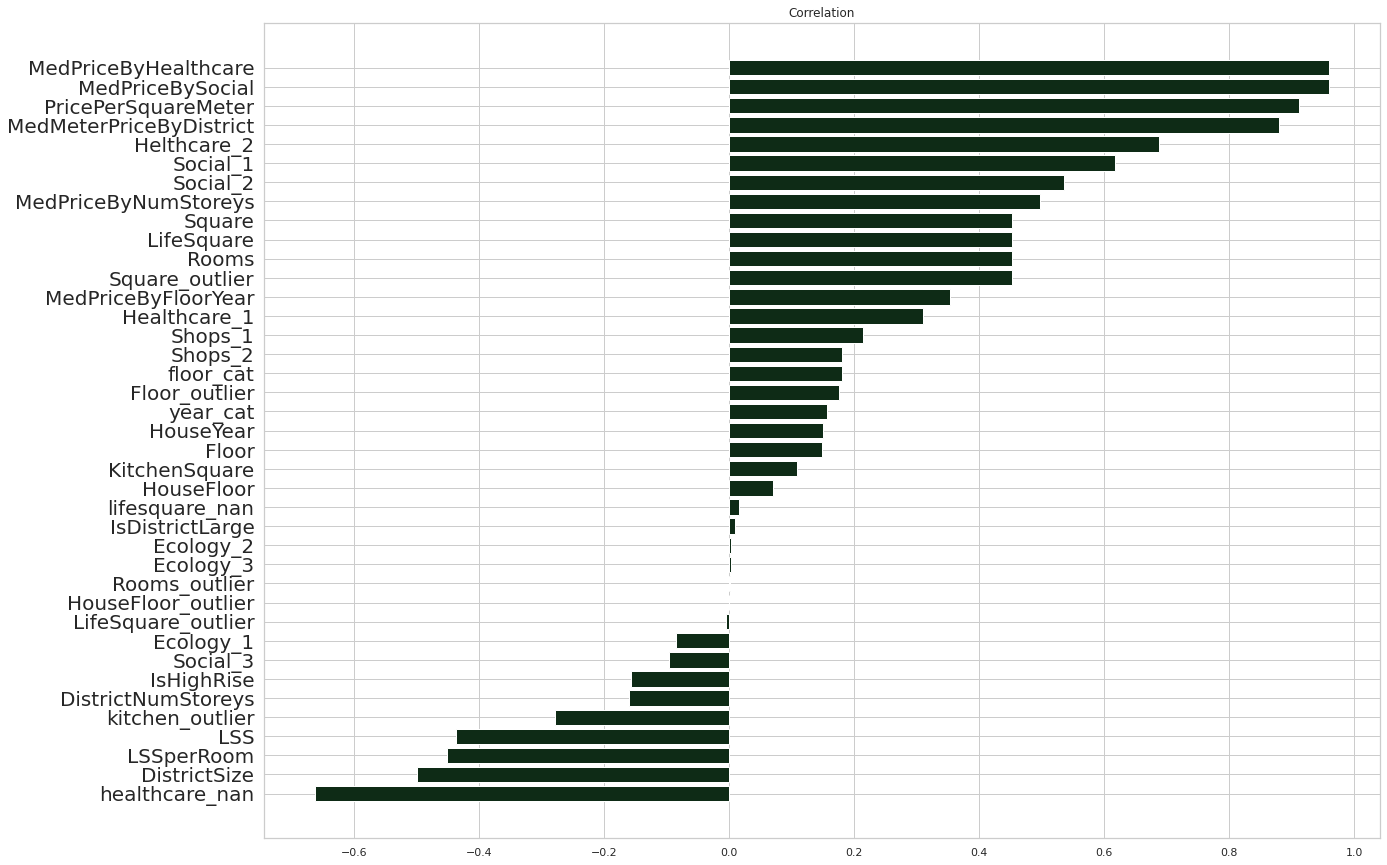

In [95]:
plt.figure(figsize=(20, 15))
make_barplot_corr(train_df, 'Price', above_null=False)

In [96]:
train_df.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'Square_outlier',
 'LifeSquare_outlier',
 'HouseFloor_outlier',
 'Floor_outlier',
 'kitchen_outlier',
 'lifesquare_nan',
 'healthcare_nan',
 'LSS',
 'LSSperRoom',
 'DistrictSize',
 'IsDistrictLarge',
 'DistrictNumStoreys',
 'IsHighRise',
 'MedPriceByNumStoreys',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear',
 'PricePerSquareMeter',
 'MedMeterPriceByDistrict',
 'MedPriceBySocial',
 'MedPriceByHealthcare']

In [97]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'Square_outlier', 'LifeSquare_outlier',
                     'HouseFloor_outlier', 'Floor_outlier', 'kitchen_outlier',
                     'lifesquare_nan', 'healthcare_nan', 'DistrictSize',
                     'IsDistrictLarge', 'DistrictNumStoreys', 'IsHighRise',
                     'MedPriceByNumStoreys', 'year_cat', 'floor_cat',
                     'MedPriceByFloorYear', 'MedMeterPriceByDistrict',
                     'MedPriceBySocial', 'MedPriceByHealthcare']

target_name = 'Price'

## Разбиение на train и test <a id='split'>

In [98]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.33, 
                                                      shuffle=True, 
                                                      random_state=21)

preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

Test R2 LifeSquare 0.6245334326318388, Train R2 LifeSquare: 0.6055031692880726
Test R2 Healthcare: 0.998967555213508, Train R2 Healtcare: 0.9993047229798728


(0, 0, 0)

## Построение модели

In [99]:
# parameters = {
#     'n_estimators': [100, 120, 150, 200, 250],
#     'max_features': np.arange(5, 9),
#     'max_depth': np.arange(5, 12),
# }

# clf = GridSearchCV(
#     estimator=RandomForestRegressor(),
#     param_grid=parameters,
#     scoring='r2',
#     cv=5,
# )
# clf.fit(X_train, y_train)
# cv_results = pd.DataFrame(clf.cv_results_)
# cv_results.columns
# param_columns = [
#     column
#     for column in cv_results.columns
#     if column.startswith('param_')
# ]

# score_columns = ['mean_test_score']

# cv_results = (cv_results[param_columns + score_columns]
#               .sort_values(by=score_columns, ascending=False))

In [100]:
# clf.best_params_
# {'max_depth': 11, 'max_features': 8, 'n_estimators': 150}

{'max_depth': 11, 'max_features': 8, 'n_estimators': 150}

In [107]:
## RandomForestRegressor
rf_model = RandomForestRegressor(max_depth=11, max_features=8, n_estimators=150, random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=11, max_features=8, n_estimators=150,
                      random_state=21)

**Оценка модели**

Train R2: 0.901,            Test R2:0.76


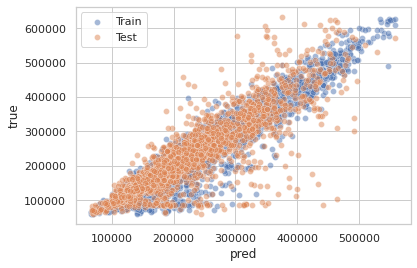

In [108]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [109]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.77668561, 0.72483718, 0.74419287, 0.75850079, 0.75073769])

In [110]:
cv_score.mean()

0.7509908303630966

**Важность признаков**

In [111]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.215548
0,Rooms,0.123846
32,MedMeterPriceByDistrict,0.108300
34,MedPriceByHealthcare,0.098965
2,LifeSquare,0.093588
33,MedPriceBySocial,0.087507
24,DistrictSize,0.042171
11,Social_2,0.023988
31,MedPriceByFloorYear,0.023024
6,HouseYear,0.021988


## Прогнозирование на тестовом датасете <a id='prediction'>

In [114]:
submit = pd.read_csv(SAMPLE_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [115]:
predictions = rf_model.predict(test_df)

In [116]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,163044.032758
1,5925,126328.794117
2,960,138991.435081
3,3848,117947.750742
4,746,179567.451818


In [117]:
submit.to_csv('rf_submit.csv', index=False)